# In this work, we will apply cell annotation to a lympnode data set by visium from 10X data. We do cell annotation by using SingleR method from R.

# First, we get the data then transform it to h5da format. Then we use Seurat to read data and find cell type labels for all cell. We can load back to python and plot the results on the cell image.

Note that we can do all those stuff by using R only and it is much easier. I just want to have fun, so I make it unnecessaryly complicated.

First thing first, we need to import libraries

In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import numpy as np

# Then, we load data from dataset provided by scanpy. The results is an anndata object. Basically, it is an object of dictionaries.

In [3]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata

AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

# QC and preprocessing

c:\Users\phill\scanpy\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

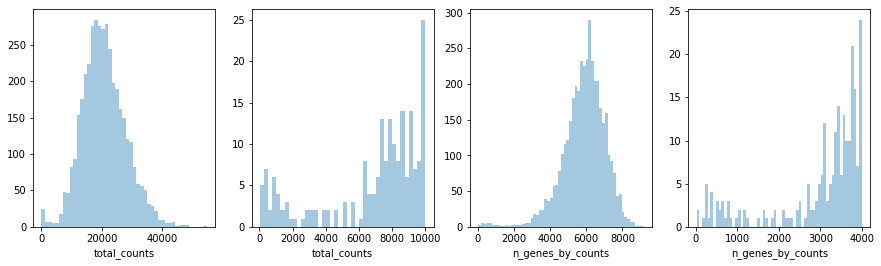

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [6]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

Trying to set attribute `.var` of view, copying.


#cells after MT filter: 3861


Normalize the data

In [7]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [8]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

c:\Users\phill\scanpy\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
c:\Users\phill\scanpy\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


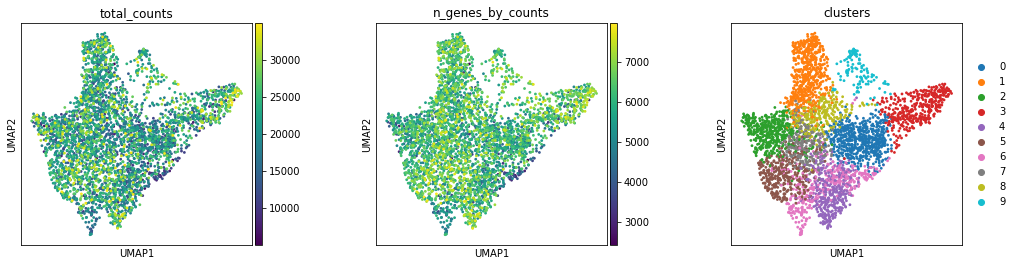

In [9]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

# Save data to h5da format for use in R

In [10]:
# adata.write_h5ad("F:\\scRNAseq annotation data\\UNIFAN\\hmlymp_node.h5ad")

# Take a look at the images of cells by total count and number of genes for each cell

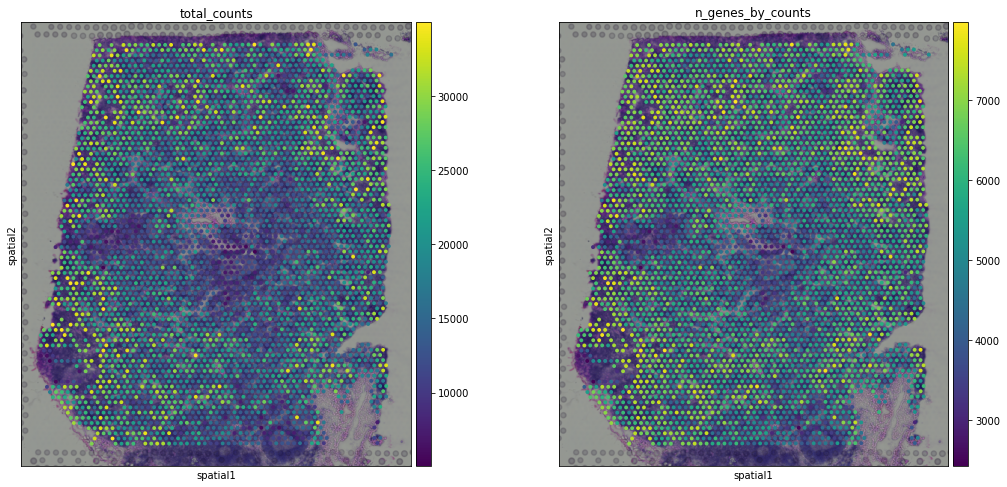

In [114]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

# Image by the cluster (10 clusters)

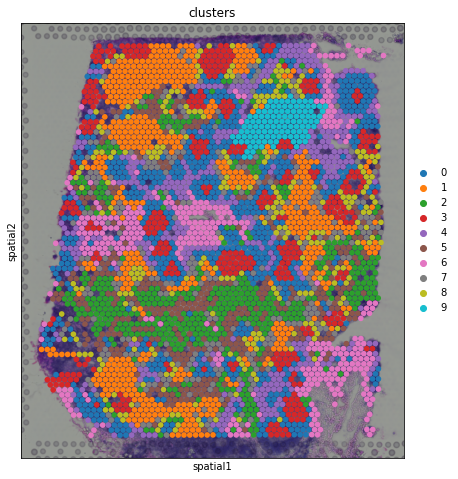

In [15]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)



# We used SingleR to get cell annotation for cell set. We apply the DatabaseImmuneCellExpressionData() reference labels for Immute cells to our lympnode dataset (See r file lympnode_anno.rmd for the details of annotation process)

In [106]:
import pandas as pd

annotation = pd.read_csv("lymp_node_annotation.csv")

In [107]:
annotation["anno_label"] = pd.Categorical(annotation["anno"])

In [73]:
annotation["anno_label"] = pd.Categorical(annotation["anno_label"])

In [108]:
annotation.index = adata.obs.index

In [110]:
annotation["anno_label"]

AAACAAGTATCTCCCA-1          B cells
AAACAATCTACTAGCA-1    T cells, CD4+
AAACAGAGCGACTCCT-1          B cells
AAACAGCTTTCAGAAG-1          B cells
AAACAGGGTCTATATT-1          B cells
                          ...      
TTGTTTCACATCCAGG-1          B cells
TTGTTTCATTAGTCTA-1          B cells
TTGTTTCCATACAACT-1          B cells
TTGTTTGTATTACACG-1    T cells, CD4+
TTGTTTGTGTAAATTC-1    T cells, CD4+
Name: anno_label, Length: 3861, dtype: category
Categories (4, object): ['B cells', 'Monocytes', 'T cells, CD4+', 'T cells, CD8+']

In [111]:
adata.obs['anno'] = annotation["anno_label"]

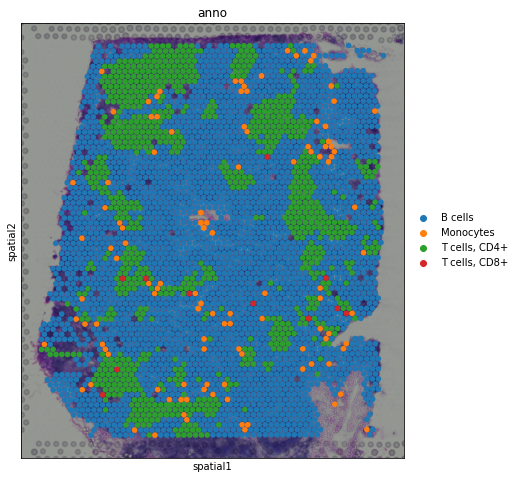

In [113]:
sc.pl.spatial(adata, img_key="hires", color="anno", size=1.5)

In [116]:
counts = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs_names)
coord = pd.DataFrame(adata.obsm['spatial'], columns=['x_coord', 'y_coord'], index=adata.obs_names)

In [118]:
coord

,x_coord,y_coord
AAACAAGTATCTCCCA-1,8346,6982
AAACAATCTACTAGCA-1,4270,1363
AAACAGAGCGACTCCT-1,7784,2672
AAACAGCTTTCAGAAG-1,1942,6159
AAACAGGGTCTATATT-1,2218,6638
...,...,...
TTGTTTCACATCCAGG-1,4218,7951
TTGTTTCATTAGTCTA-1,3392,8192
TTGTTTCCATACAACT-1,3181,6396
TTGTTTGTATTACACG-1,4153,9747


In [117]:
counts

,AL627309.1,AL627309.5,LINC01409,LINC01128,LINC00115,FAM41C,LINC02593,SAMD11,NOC2L,KLHL17,...,MT-ND6,MT-CYB,BX004987.1,AC145212.1,MAFIP,AC011043.1,AL354822.1,AL592183.1,AC007325.4,AC007325.2
AAACAAGTATCTCCCA-1,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.523510,0.000000,...,0.000000,2.402181,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
AAACAATCTACTAGCA-1,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.940698,0.577110,...,0.000000,2.942350,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.000000,0.813868,0.000000,0.0,0.000000,0.000000,1.256539,0.487543,...,0.000000,2.457987,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
AAACAGCTTTCAGAAG-1,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.499758,3.340368,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
AAACAGGGTCTATATT-1,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.489888,1.063468,0.489888,...,0.817251,2.658495,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0.0,0.0,0.000000,0.703402,0.000000,0.0,0.703402,0.000000,0.000000,0.000000,...,0.703402,2.503628,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
TTGTTTCATTAGTCTA-1,0.0,0.0,0.657702,0.000000,0.000000,0.0,0.000000,0.000000,1.332644,0.000000,...,0.000000,2.572197,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
TTGTTTCCATACAACT-1,0.0,0.0,0.000000,1.032711,0.000000,0.0,0.000000,0.000000,0.644133,0.000000,...,0.000000,2.546029,0.0,0.0,0.000000,0.644133,0.0,0.000000,0.000000,0.0
TTGTTTGTATTACACG-1,0.0,0.0,0.968731,0.000000,0.000000,0.0,0.000000,0.000000,0.968731,0.000000,...,0.000000,3.102333,0.0,0.0,0.968731,0.000000,0.0,0.000000,0.000000,0.0
